In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
import tensorwatch as tw
from torchvision import models
from torchsummary import summary  # 输出网络模型结构的相关包
from matplotlib import pyplot as plt  # 导入matplotlib库，用于绘图

from utils import plot_image, plot_curve, one_hot  # 导入自定义的一些工具函数

# import os  # 导入os库，用于操作系统相关的功能
# os.environ[
#     'KMP_DUPLICATE_LIB_OK']='TRUE'   # 设置一个环境变量，防止出现重复的库的错误
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # （自己添加）

batch_size = 512  # 设置每个批次的数据量为512

torch.Size([512, 1, 28, 28]) torch.Size([512]) tensor(-0.4242) tensor(2.8215)


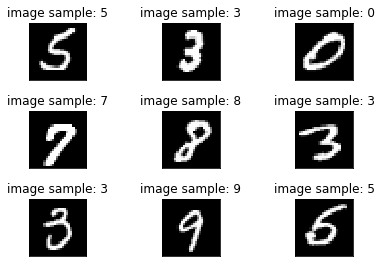

In [2]:
# 创建一个训练数据加载器，使用torchvision.datasets.MNIST方法下载并加载MNIST手写数字数据集
# 使用torchvision.transforms.Compose方法对数据进行预处理，包括转换为张量和归一化
# 使用torch.utils.data.DataLoader方法将数据封装成批次，并打乱顺序
train_loader = torch.utils.data.DataLoader(

    torchvision.datasets.MNIST('mnist_data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('mnist_data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size, shuffle=False)

x, y = next(iter(train_loader))  # 使用next(iter())方法从训练数据加载器中获取下一个批次的数据，包括输入x和标签y
print(x.shape, y.shape, x.min(), x.max())  # 打印x和y的形状、x的最小值和最大值

plot_image(x, y, 'image sample')

# 移动到GPU上
x = x.to(device)  # （自己添加）
y = y.to(device)  # （自己添加）

In [3]:
class Net(nn.Module):
    # 定义神经网络模型类Net继承nn.Module类

    def __init__(self):
        # 定义模型的初始化方法

        super(Net, self).__init__()
        # 继承并执行父类（nn.Module）的初始化方法
        # xw+b
        self.fc1 = nn.Linear(28 * 28, 256)
        # 第一层全连接层，输入特征向量28*28，输出特征向量256
        self.fc2 = nn.Linear(256, 64)
        # 第二层全连接层，输入特征向量256，输出特征向量64
        self.fc3 = nn.Linear(64, 10)
        # 第三层全连接层，输入特征向量64，输出特征向量10

    def forward(self, x):
        # 定义前向传播计算过程的方法forward，输入参数x是模型输入

        # x: [b, 1, 28, 28]
        # h1 = relu(xw1+b1)
        x = F.relu(self.fc1(x))
        # 将第一层的输出传递到第二层，并应用ReLU激活函数 进行非线性变换
        # h2 = relu(h1w2+b2)
        x = F.relu(self.fc2(x))
        # h1作为输入通过第二层全连接层计算得到h2，并应用激活函数relu进行非线性变换
        # h3 = h2w3+b3
        x = self.fc3(x)
        # h2作为输入通过第三层全连接层计算得到输出结果h3
        return x


net = Net()
# 移动模型到GPU上    # print(next(net.parameters()).device)  # 返回cuda值
net = net.to(device)  # 网络加载到GPU运行（自己添加）

################ 输出网络结构
summary(net, input_size=(28 * 28,))  # 调用summary函数，输入模型和输入大小

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
            Linear-2                   [-1, 64]          16,448
            Linear-3                   [-1, 10]             650
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.83
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


epoch: 0 迭代次数: 0 loss: 2.297152042388916
epoch: 0 迭代次数: 10 loss: 2.2028071880340576
epoch: 0 迭代次数: 20 loss: 1.9420967102050781
epoch: 0 迭代次数: 30 loss: 1.3867895603179932
epoch: 0 迭代次数: 40 loss: 0.8763126134872437
epoch: 0 迭代次数: 50 loss: 0.694456160068512
epoch: 0 迭代次数: 60 loss: 0.5136757493019104
epoch: 0 迭代次数: 70 loss: 0.4057026505470276
epoch: 0 迭代次数: 80 loss: 0.44441959261894226
epoch: 0 迭代次数: 90 loss: 0.407986581325531
epoch: 0 迭代次数: 100 loss: 0.38050058484077454
epoch: 0 迭代次数: 110 loss: 0.3373958468437195
epoch: 0 迭代次数: 117 loss: 0.222 Train accuracy: 53969.0/60000 (90%)

epoch: 1 迭代次数: 0 loss: 0.3242463171482086
epoch: 1 迭代次数: 10 loss: 0.40228569507598877
epoch: 1 迭代次数: 20 loss: 0.3475707769393921
epoch: 1 迭代次数: 30 loss: 0.3045910894870758
epoch: 1 迭代次数: 40 loss: 0.2621379792690277
epoch: 1 迭代次数: 50 loss: 0.3181283175945282
epoch: 1 迭代次数: 60 loss: 0.3054646849632263
epoch: 1 迭代次数: 70 loss: 0.32532232999801636
epoch: 1 迭代次数: 80 loss: 0.26907825469970703
epoch: 1 迭代次数: 90 loss: 0.2

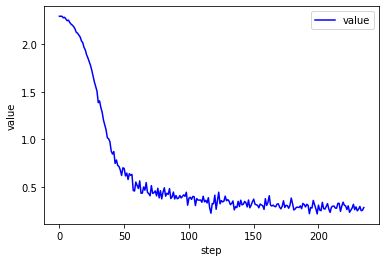

In [4]:
###################优化器
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)  # 创建一个 梯度下降SGD 优化器，用来更新 net 模型的参数
# optimizer = optim.Adam(net.parameters(), lr=0.0001)  # 基于自适应学习率的优化器，它可以根据每个参数的梯度历史动态调整学习率，从而加速收敛

#####################训练
train_loss = []
for epoch in range(2):  # epoch是所有数据都放入模型训练的次数

    for batch_idx, (x, y) in enumerate(train_loader):  # batch_idx即iteration，表示迭代次数

        # x: [b, 1, 28, 28], y: [512]
        # [b, 1, 28, 28] => [b, 784]
        x = x.to(device)
        y = y.to(device)
        x = x.view(x.size(0), 28 * 28)
        # => [b, 10]
        out = net(x)
        y_onehot = one_hot(y)
        # loss = mse(out, y_onehot)
        # loss=F.mse_loss(out,y_onehot)  # 均方误差
        loss_func = torch.nn.CrossEntropyLoss()  # 直接使用pytorch内置的交叉熵损失函数
        loss = loss_func(out, y_onehot)  # 直接使用pytorch内置的交叉熵损失函数

        optimizer.zero_grad()
        loss.backward()
        # w' = w - lr*grad
        optimizer.step()

        train_loss.append(loss.item())  # 将当前批次的损失值转换为Python数值并添加到train_loss列表中

        if batch_idx % 10 == 0:
            print('epoch:', epoch, '迭代次数:', batch_idx, 'loss:', loss.item())
        ############### 输出训练准确度
        train_correct = 0  # 定义一个变量，用于记录训练过程中的正确预测数
    total = 0  # 定义一个变量，用于记录训练过程中的总样本数
    for data in train_loader:  # 开始一个循环，遍历训练数据加载器(train_loader)中的每一批数据
        x, y = data  # 将每一批数据分解为输入特征(x)和标签(y)
        x = x.to(device)  # 将输入特征转移到GPU上
        y = y.to(device)  # 将标签转移到GPU上
        x = x.view(x.size(0), 28 * 28)  # 将输入特征变形为二维张量，第一维是批量大小，第二维是28*28，即图片的像素数
        out = net(x)  # 调用模型(net)，输入特征，输出预测值(out)
        pred = out.argmax(dim=1)  # 对预测值进行argmax操作，沿着第二维(即每个样本的10个类别概率)，取最大值的索引，得到预测类别(pred)
        correct = pred.eq(
            y).sum().float().item()  # 对预测类别和标签进行比较，使用eq函数得到一个布尔张量，表示哪些样本预测正确，然后对其求和，转换为浮点数，并取出其中的数值，得到这一批数据中的正确预测数(
        # correct)
        train_correct += correct  # 将正确预测数累加到train_correct变量中
        total += y.size(0)  # 将这一批数据的样本数累加到total变量中
        train_acc = 100*train_correct / total  # 计算训练精度(train_acc)，即正确预测数除以总样本数
    print('epoch: {} 迭代次数: {} loss: {:.3f} Train accuracy: {}/{} ({:.1f}%)\n'.format(epoch, batch_idx, loss.item(),
                                                                                     train_correct, total,
                                                                                     train_acc))  # 打印当前轮数(epoch)，当前迭代次数(batch_idx)，当前损失(loss)，和当前训练精度(train_acc)

plot_curve(train_loss)  # 输出loss变化曲线图

Test accuracy:9231.0/10000 (92.3%)



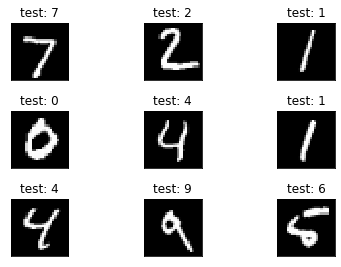

In [8]:
######### 测试（利用测试数据）
total_correct = 0
for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)
    x = x.view(x.size(0), 28 * 28)
    out = net(x)
    # out: [b, 10] => pred: [b]
    pred = out.argmax(dim=1)
    correct = pred.eq(y).sum().float().item()
    total_correct += correct

total_num = len(test_loader.dataset)
acc = 100*total_correct / total_num
print('Test accuracy:{}/{} ({:.1f}%)\n'.format( total_correct, total_num, acc))

######### 测试 推理，示例；新的图片输入模型，输出预测值
x, y = next(iter(test_loader))  # 从测试数据加载器(test_loader)中取出第一批数据，分解为输入特征(x)和标签(y)
x = x.to(device)  # 将输入特征转移到GPU上
# y=y.cuda()  # 将标签转移到GPU上（这一行被注释掉了，可能是因为不需要用到标签）
out = net(x.view(x.size(0), 28 * 28))  # 调用模型(net)，输入特征，输出预测值(out)，其中输入特征被变形为二维张量，第一维是批量大小，第二维是28*28，即图片的像素数
pred = out.argmax(dim=1)  # 对预测值进行argmax操作，沿着第二维(即每个样本的10个类别概率)，取最大值的索引，得到预测类别(pred)
pred = pred.to(device).data.cpu()  # 将预测类别从GPU上转移到CPU上，并取出其中的数据部分
x = x.to(device).data.cpu()  # 将输入特征从GPU上转移到CPU上，并取出其中的数据部分
plot_image(x, pred, 'test')  # 调用plot_image函数，输入特征，预测类别和标题('test')，绘制图片和预测结果

In [9]:
####################模型保存 保存整个网络
# torch.save(net, './Regression_model_.pt')
torch.save({
    'epoch': epoch,
    # 'model_state_dict': net.state_dict(),
    # 'optimizer_state_dict': optimizer.state_dict(),
    'Testacc': acc,
    'TrainAcc': train_acc,
    'Batchsize': batch_size,
},
    f"model_Batchsize{batch_size}_epoch{epoch}_TrainAcc{train_acc:.3f}_TestAcc{acc:.3f}.pth")  # 文件名是一个格式化字符串(f-string)，包含模型名称(model)，批量大小(Batchsize)，训练轮数(epoch)，训练精度(TrainAcc)和测试精度(TestAcc)，以及文件扩展名(.pth)
# 读取
# use_model = torch.load('./Train_model.pt')